<a href="https://colab.research.google.com/github/pisalrutuja/MRI/blob/main/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import os
from os import listdir
import numpy as np
from numpy import asarray
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from keras.utils.vis_utils import plot_model
import imageio
import glob
from skimage.transform import resize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  8 09:48:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Let's write a function for loading and resizing images
def load_mri_images(path, size=(256,256)):
    list_of_data = list()
    
    for filename in listdir(path):     
        pixels = load_img(path +'/'+ filename, target_size=size)
        pixels = img_to_array(pixels) # convert to numpy array
        list_of_data.append(pixels) # storing the data for further processing
    return asarray(list_of_data)

In [6]:
# load dataset from tr1 folder i.e. TR1 MRI images

tr1_data = load_mri_images('/content/drive/MyDrive/GAN/Tr1/TrainT1') 
tr1_data = tf.image.rgb_to_grayscale(tr1_data) #convert to grayscale
tr1= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr1

<TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

In [7]:
tr2_data = load_mri_images('/content/drive/MyDrive/GAN/Tr2/TrainT2')
tr2_data = tf.image.rgb_to_grayscale(tr2_data) #convert to grayscale
tr2= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))
tr2

<TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

### **2.2. Data Visualization**  
  **Visualizing TR1 MRI**


*   Sample image from dataset
*   Shape of TR1 dataset








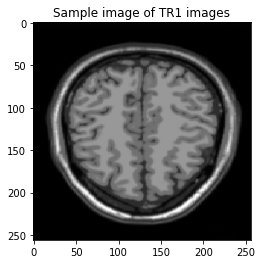

In [8]:
plt.title('Sample image of TR1 images')
plt.imshow(tr1_data[0].numpy().reshape(256,256), cmap='gray')

In [9]:
tr1_data.shape

TensorShape([53, 256, 256, 1])

**Visualizing TR2 MRI**
* Sample image from dataset
* Shape of TR2 dataset





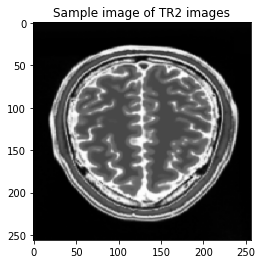

In [10]:
plt.title('Sample image of TR2 images')
plt.imshow(tr2_data[0].numpy().reshape(256,256), cmap='gray')

In [11]:
tr2_data.shape

TensorShape([46, 256, 256, 1])

In [12]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [13]:
# Creating function for normalizing the images to [-1, 1]
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1 
    return image

In [14]:
# Creating function for pre-processing of images along with normalization
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)   
    return image

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

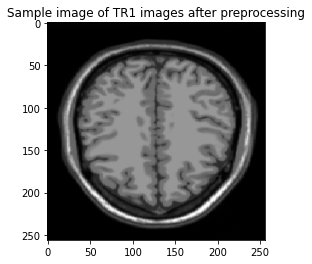

In [17]:
# Visualizing TR1
plt.title('Sample image of TR1 images after preprocessing')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

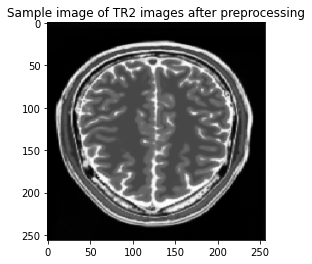

In [18]:
plt.title('Sample image of TR2 images after preprocessing')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

In [19]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [20]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [21]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [22]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
   
    down_stack = [
      downsample(64, 4, apply_norm=False), 
      downsample(128, 4), 
      downsample(256, 4),  
      downsample(512, 4),  
      downsample(512, 4), 
      downsample(512, 4),  
      downsample(512, 4),  
      downsample(512, 4),  
    ]#created a stack of downsample models
                  
    up_stack = [
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4),  
      upsample(256, 4),  
      upsample(128, 4),  
      upsample(64, 4),  
        ] #created a stack of upsample models
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') 
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
generator_g = unet_generator() #initialise the generator
generator_f = unet_generator() #initialise the generator

In [24]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   1024        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                          

In [25]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4,  False)(x)  #code to downsample X
    down2 = downsample(128, 4)(down1)     #code to downsample down1
    down3 = downsample(256, 4)(down2)     #code to downsample down2
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
    return tf.keras.Model(inputs=inp, outputs=last) #model using input & output layer

In [26]:
discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

In [27]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 1)]   0         
                                                                 
 sequential_30 (Sequential)  (None, None, None, 64)    1024      
                                                                 
 sequential_31 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_32 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, None, None, 256)  0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

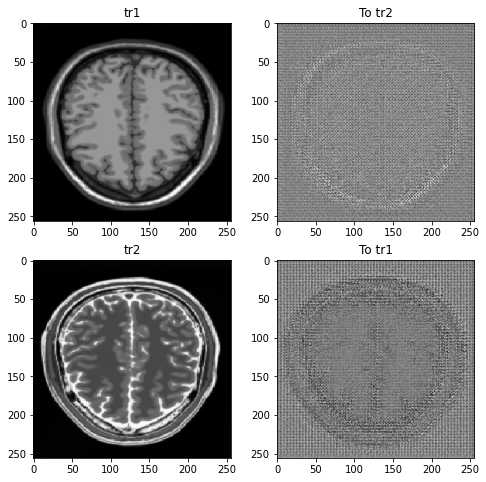

In [28]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [29]:
LAMBDA = 10

In [30]:
# Using Binarycross entropy with logits true
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
# calculating discriminator loss by summing the real and generated
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real) 
    generated_loss = loss_obj(tf.zeros_like(generated), generated) 
    total_disc_loss = real_loss + generated_loss 
    return total_disc_loss * 0.5

In [32]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [33]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) 
    return LAMBDA * loss1

In [34]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [35]:
# Optimizer with learning rate 2e-4 for generator and discriminator
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
EPOCHS = 200

In [37]:
checkpoint_path = './checkpoints'  
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [37]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input:T1', 'Predicted: T1->T2 ', 'Input: T2', 'Predicted: T2->T1']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/GAN/output/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [38]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)  # code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training=True) # code to generate images susiing Generator_f on fake_y
        
        fake_x =  generator_f(real_y, training=True) # code to generate images using Generator_f on real_y
        cycled_y = generator_g(fake_x, training=True) # code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True) # code to generate images using Generator_f on real_x
        same_y = generator_g(real_y, training=True) # code to generate images using Generator_g on real_y
        
        disc_real_x =  discriminator_x(real_x, training=True) # code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training=True) # code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x, training=True) # code to discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y, training=True) #code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculating the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculating the generator_loss for disc_fake_X 
        
        #calculate the total cycle loss
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
         
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculating the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculating the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculating the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables) 
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables) 
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    
    # Applying the gradients to the optimizer
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables)) #write your code here

In [37]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, generator_f, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [37]:
anim_file = '/content/drive/MyDrive/GAN/cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/GAN/output/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [37]:
pip install git+https://github.com/tensorflow/docs

In [37]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)